In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/euro-and-dollar-currency/EUR_USD_DATA.csv


In [2]:
%%capture
!pip install yfinance chainer plotly distutils

In [3]:
# Import necessary libraries
import yfinance as yf
import datetime
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from matplotlib import pyplot as plt
from plotly.offline import iplot
from plotly.graph_objs import Candlestick, Figure
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# **1-Loading the Data & Data Preparation**

First few rows of the dataframe:
         Date      Open      High       Low     Close  Adj Close  Volume  RSI  \
0  2012-01-02  1.296008  1.296395  1.292257  1.296008   1.296008       0  NaN   
1  2012-01-03  1.293628  1.306592  1.293628  1.294096   1.294096       0  NaN   
2  2012-01-04  1.305398  1.307395  1.290206  1.305602   1.305602       0  NaN   
3  2012-01-05  1.293092  1.294297  1.278527  1.293142   1.293142       0  NaN   
4  2012-01-06  1.279296  1.281296  1.270406  1.279607   1.279607       0  NaN   

        SAR  ADX  ...  slowk  slowd  fastk  fastd  TRIX  ULTOSC  WILLR  ATR  \
0       NaN  NaN  ...    NaN    NaN    NaN    NaN   NaN     NaN    NaN  NaN   
1       NaN  NaN  ...    NaN    NaN    NaN    NaN   NaN     NaN    NaN  NaN   
2  1.292257  NaN  ...    NaN    NaN    NaN    NaN   NaN     NaN    NaN  NaN   
3  1.307395  NaN  ...    NaN    NaN    NaN    NaN   NaN     NaN    NaN  NaN   
4  1.307395  NaN  ...    NaN    NaN    NaN    NaN   NaN     NaN    NaN  NaN   

   NA

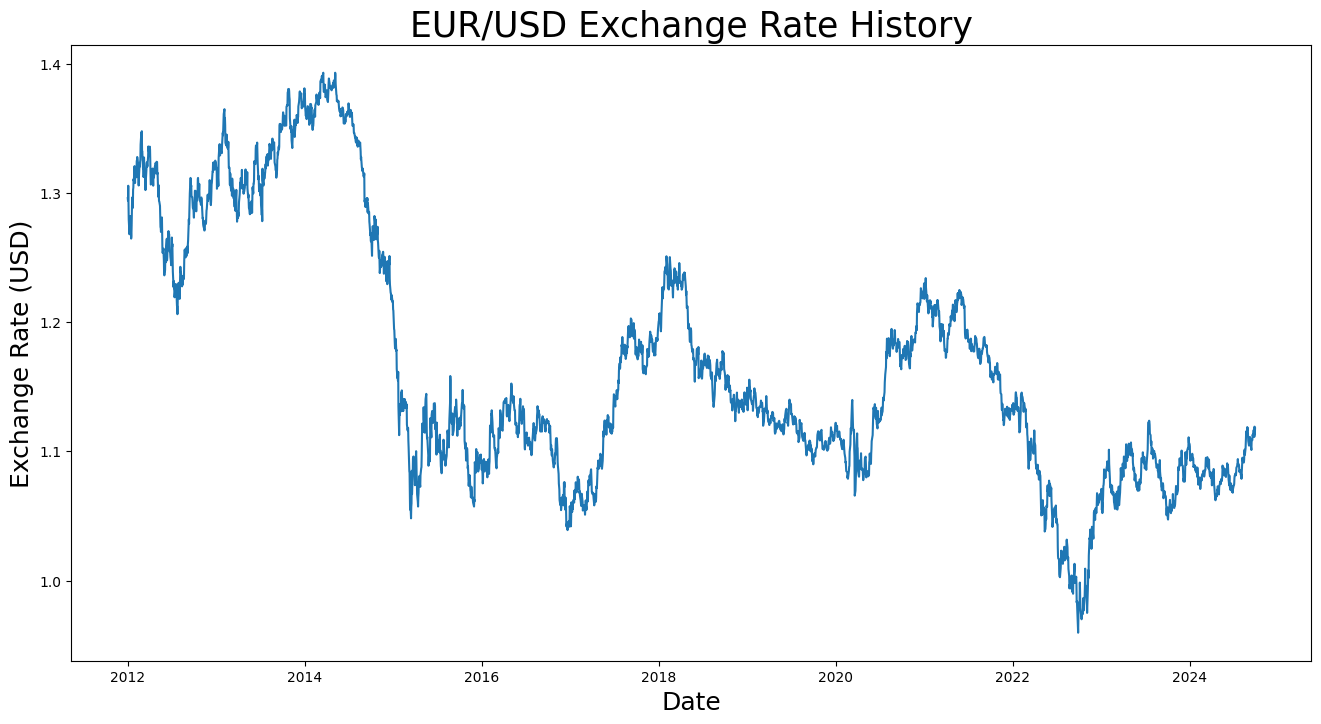

In [4]:
# Read the data from CSV file
df = pd.read_csv('/kaggle/input/euro-and-dollar-currency/EUR_USD_DATA.csv')

# Display the first few rows of the dataframe
print("First few rows of the dataframe:")
print(df.head())

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Print the minimum and maximum dates in the index
print("Date range in the dataset:")
print(df.index.min(), df.index.max())

# Plot the close price history
plt.figure(figsize=(16, 8))
plt.title('EUR/USD Exchange Rate History', fontsize=25)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Exchange Rate (USD)', fontsize=18)
plt.show()

# **2-Split Data**

In [5]:
# Define the date to split the data
date_split = '2020-08-01'

# Split the DataFrame into training and testing sets
train = df[:date_split]
test = df[date_split:]

# Output the lengths of the training and testing sets
print("Length of training set:", len(train))
print("Length of testing set:", len(test))

Length of training set: 2235
Length of testing set: 1085


In [6]:
def plot_train_test(train, test, date_split):
    # Create candlestick charts for train and test data
    data = [
        go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
    
    # Define layout with shapes and annotations
    layout = go.Layout(
        shapes=[
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
        ],
        annotations=[
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    )
    
    # Create figure and plot it
    figure = go.Figure(data=data, layout=layout)
    iplot(figure)

In [7]:
# Assume train and test are already defined DataFrames, and date_split is the date used to split the data
plot_train_test(train, test, date_split)

# **3-Define the environment**

In [8]:
class Environment1:
    """
    A simple trading environment for reinforcement learning.

    Attributes:
        data (pd.DataFrame): The stock data.
        history_t (int): The length of the historical data to consider.
        t (int): The current time step.
        done (bool): Whether the episode is finished.
        profits (float): The total profits accumulated.
        positions (list): List of positions held.
        position_value (float): The current value of the held positions.
        history (list): List of historical price changes.
    """

    def __init__(self, data, history_t=90):
        """
        Initializes the environment with stock data and history length.

        Args:
            data (pd.DataFrame): The stock data.
            history_t (int): The length of the historical data to consider.
        """
        self.data = data
        self.history_t = history_t
        self.reset()

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
            list: The initial observation of the environment.
        """
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history

    def step(self, act):
        """
        Takes a step in the environment based on the action.

        Args:
            act (int): The action to take (0: stay, 1: buy, 2: sell).

        Returns:
            tuple: The next observation, reward, and whether the episode is done.
        """
        reward = 0

        if act == 1:  # buy
            self.positions.append(self.data.iloc[self.t]['Close'])
        elif act == 2:  # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # Set next time step
        self.t += 1

        if self.t >= len(self.data) - 1:
            self.done = True

        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t]['Close'] - p)

        self.history.pop(0)
        self.history.append(self.data.iloc[self.t]['Close'] - self.data.iloc[self.t - 1]['Close'])

        # Clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1

        return [self.position_value] + self.history, reward, self.done

In [9]:
# Assuming the Environment1 class has been defined as shown previously

# Initialize the environment with the training data
env = Environment1(train)

# Reset the environment and print the initial observation
initial_observation = env.reset()
print("Initial Observation:", initial_observation)

# Perform a few random actions and print the results
for _ in range(3):
    action = np.random.randint(3)  # Randomly choose an action (0: stay, 1: buy, 2: sell)
    observation, reward, done = env.step(action)
    print(f"Action: {action}, Observation: {observation}, Reward: {reward}, Done: {done}")

Initial Observation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Action: 0, Observation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0019118785858156517], Reward: 0, Done: False
Action: 0, Observation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0019118785858156517, 0.011505961418151855], Reward: 0, Done: False


# **4-Define the Q-network**

In [10]:
class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the training function
def train_dqn(env):
    input_size = env.history_t + 1
    hidden_size = 100
    output_size = 3
    
    Q = QNetwork(input_size, hidden_size, output_size)
    Q_ast = QNetwork(input_size, hidden_size, output_size)
    Q_ast.load_state_dict(Q.state_dict())
    optimizer = optim.Adam(Q.parameters())
    
    epoch_num = 300
    step_max = len(env.data) - 1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5
    
    memory = deque(maxlen=memory_size)
    total_step = 0
    total_rewards = []
    total_losses = []
    
    start = time.time()
    for epoch in range(epoch_num):
        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        
        while not done and step < step_max:
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                with torch.no_grad():
                    pact = Q(torch.FloatTensor(pobs).unsqueeze(0)).argmax().item()
            
            obs, reward, done = env.step(pact)
            memory.append((pobs, pact, reward, obs, done))
            
            if len(memory) >= memory_size:
                if total_step % train_freq == 0:
                    batch = random.sample(memory, batch_size)
                    b_pobs, b_pact, b_reward, b_obs, b_done = zip(*batch)
                    
                    b_pobs = torch.FloatTensor(b_pobs)
                    b_pact = torch.LongTensor(b_pact)
                    b_reward = torch.FloatTensor(b_reward)
                    b_obs = torch.FloatTensor(b_obs)
                    b_done = torch.BoolTensor(b_done)
                    
                    q = Q(b_pobs)
                    maxq = Q_ast(b_obs).max(1)[0]
                    target = q.clone().detach()
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j] + gamma * maxq[j] * (not b_done[j])
                    
                    loss = nn.functional.mse_loss(q, target)
                    total_loss += loss.item()
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                if total_step % update_q_freq == 0:
                    Q_ast.load_state_dict(Q.state_dict())
            
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease
            
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1
        
        total_rewards.append(total_reward)
        total_losses.append(total_loss)
        
        if (epoch + 1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch + 1) - show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch + 1) - show_log_freq):]) / show_log_freq
            elapsed_time = time.time() - start
            print('\t'.join(map(str, [epoch + 1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
    
    return Q, total_losses, total_rewards

# Running the training
Q, total_losses, total_rewards = train_dqn(Environment1(train))

5	0.0999999999999992	11170	-22.6	6.633863931629483	20.27304172515869
10	0.0999999999999992	22340	3.2	7.019692831247812	21.25631880760193
15	0.0999999999999992	33510	58.8	9.465979000163497	18.46714448928833
20	0.0999999999999992	44680	85.6	11.436551621602849	16.75815987586975
25	0.0999999999999992	55850	173.2	15.099232157273217	16.2641704082489
30	0.0999999999999992	67020	171.8	13.643440192565322	15.053800582885742
35	0.0999999999999992	78190	149.6	11.710934242443182	15.875717401504517
40	0.0999999999999992	89360	196.8	14.070890233386308	14.648552656173706
45	0.0999999999999992	100530	237.0	13.803462693095208	14.623349666595459
50	0.0999999999999992	111700	267.4	14.947681323625147	14.170262098312378
55	0.0999999999999992	122870	305.6	13.963841290585696	14.1150062084198
60	0.0999999999999992	134040	288.0	13.394281812943518	13.933117866516113
65	0.0999999999999992	145210	305.6	14.462911131046713	13.790912866592407
70	0.0999999999999992	156380	316.0	12.85064713433385	14.118850231170654
75	

In [11]:
def plot_loss_reward(total_losses, total_rewards):
    # Create subplots with two columns
    figure = make_subplots(rows=1, cols=2, subplot_titles=('Loss', 'Reward'))

    # Add traces for losses and rewards
    figure.add_trace(go.Scatter(y=total_losses, mode='lines', line=dict(color='skyblue'), name='Loss'), row=1, col=1)
    figure.add_trace(go.Scatter(y=total_rewards, mode='lines', line=dict(color='orange'), name='Reward'), row=1, col=2)

    # Update x-axis titles
    figure.update_xaxes(title_text='Epoch', row=1, col=1)
    figure.update_xaxes(title_text='Epoch', row=1, col=2)

    # Update layout
    figure.update_layout(height=400, width=900, showlegend=False)

    # Plot the figure
    figure.show()

In [12]:
plot_loss_reward(total_losses, total_rewards)

In [13]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name, date_split):
    # Train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data) - 1):
        pact = Q(torch.FloatTensor(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = torch.argmax(pact.data).item()
        train_acts.append(pact)
        
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)
        pobs = obs
        
    train_profits = train_env.profits
    
    # Test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data) - 1):
        pact = Q(torch.FloatTensor(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = torch.argmax(pact.data).item()
        test_acts.append(pact)
        
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)
        pobs = obs
        
    test_profits = test_env.profits
    
    # Plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        go.Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        go.Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        go.Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        go.Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        go.Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        go.Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    
    layout = {
        'title': title,
        'showlegend': False,
        'shapes': [
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
        ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    
    figure = go.Figure(data=data, layout=layout)
    iplot(figure)

In [14]:
# Run the plot function
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN', "2023-08-01")